In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langsmith langchain_experimental langchain-chroma pypdf sentence-transformers

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY", "")
os.environ["LANGCHAIN_PROJECT"] = "langgraph_multi_agent_blog"
os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY", "")
os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY", "")



In [6]:
from maxim import Config, Maxim
from maxim.decorators import current_trace, span, trace, current_span
from maxim.logger.components.span import Span, SpanConfig
from maxim.logger.components.trace import Trace
from maxim.logger.components.toolCall import ToolCallConfig, ToolCall
from maxim.logger.components.generation import Generation,GenerationConfig
from maxim.decorators.langchain import langchain_callback, langgraph_agent
from maxim.logger import LoggerConfig

### Setup API Keys

In [7]:
maxim_api_key = os.environ.get("MAXIM_API_KEY", "")
maxim_base_url = os.environ.get("MAXIM_BASE_URL", "")
maxim_repo_id = os.environ.get("MAXIM_LOG_REPO_ID", "")
logger = Maxim(Config(api_key=maxim_api_key, debug=True, base_url=maxim_base_url)).logger(
    LoggerConfig(id=maxim_repo_id)
)

### Creating LLM

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o")

### Websearch Tool

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

### RAG tool

In [10]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./content/docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Unsupported file type: .DS_Store


Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not reliably determine page label for 3.
Could not rel

Loaded 1197 documents from the folder.


In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 2104 chunks.


In [12]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

/var/folders/yx/5c9yh5jn1hxgw1_0s05ml2g40000gn/T/ipykernel_74876/694609584.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/opt/homebrew/Caskroom/miniconda/base/envs/maxim-sdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vector store created and persisted to './chroma_db'


In [13]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("What is eigen value?")
print(retriever_results)

[Document(id='2f9d165e-5f0a-4b58-9fe0-787cabb8c18a', metadata={'page': 301, 'page_label': '282', 'source': './content/docs/Linear Algebra Done Right -- Sheldon Axler -- Undergraduate Texts in Mathematics, Undergraduate Texts in -- Springer -- 9783031410253 -- cfa307eadf1ba599852902534dfa18f2 -- Anna’s Archive.pdf'}, page_content='Then a computer can be asked to find an approximation for the largest eigenvalue\nof 𝑇∗𝑇 (excellent numeric algorithms exist for this purpose). Then taking the\nsquare root and using 7.88(a) gives an approximation for the norm of 𝑇 (which\nusually cannot be computed exactly).'), Document(id='e800298a-e738-4020-9ea0-f420812395cd', metadata={'page': 301, 'page_label': '282', 'source': './content/docs/Linear Algebra Done Right -- Sheldon Axler -- Undergraduate Texts in Mathematics, Undergraduate Texts in -- Springer -- 9783031410253 -- cfa307eadf1ba599852902534dfa18f2 -- Anna’s Archive.pdf'}, page_content='Then a computer can be asked to find an approximation for

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to FutureSmart AI"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_result = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

### NL2SQL Tool

In [15]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: command not found: wget


In [16]:
!mv Chinook_Sqlite.sqlite Chinook.db

mv: Chinook_Sqlite.sqlite: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [18]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [19]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']

# question = "How many employees are there?"
# result = nl2sql_tool.invoke({"question": question})
# print(f"Question: {question}")
# print(f"Answer: {result}")

INSIDE NL2SQL TOOL


/var/folders/yx/5c9yh5jn1hxgw1_0s05ml2g40000gn/T/ipykernel_74876/2486716521.py:16: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


Question: How many employees are there?
Answer: Error: (sqlite3.OperationalError) near "To": syntax error
[SQL: To answer your question correctly, I need to know which tables and their columns are available in the database schema you are referring to. Since you have not provided any tables or schema details, I cannot proceed with creating a SQL query. Please provide the relevant table structure details, and I'll be happy to assist you further!]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


### Create Supervisor Agent

In [20]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


members = ["web_researcher", "rag", "nl2sql"]
# Our supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["web_researcher", "rag", "nl2sql","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

### Create Web Research, RAG and NL2SQL Agent

In [21]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [22]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import (
    Runnable,
    RunnableBinding,
    RunnableConfig,
)
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph._api.deprecation import deprecated_parameter
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

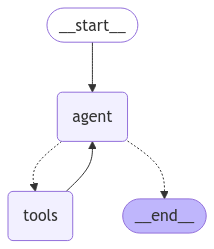

In [23]:
websearch_agent = create_agent(llm, [web_search_tool])

from IPython.display import Image, display

try:
    display(Image(websearch_agent.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [24]:
def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [26]:
result = websearch_agent.invoke({"messages": [("user", "what is the weather in delhi today?")]})

In [27]:
result['messages'][-1].content

'The weather in Delhi today has a temperature of approximately 19.76°C, with a forecasted range between 10.05°C and 24.97°C.'

In [28]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [29]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

In [30]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()

In [31]:
@langgraph_agent(name="multi-agent-work")
def ask_agent(user_message:str):
    config = {"callbacks": [langchain_callback()]}
    for s in graph.stream(input={"messages": [("user", user_message)],}, config=config,subgraphs=True):
        print(s)
        print("----")

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [35]:
from flask import Flask, jsonify, request
flask_app = Flask(__name__)

In [36]:
@flask_app.post("/chat")
@trace(logger=logger, name="movie-search-v1")
def chat():
    query = request.json["query"]
    response = ask_agent(query)
    return jsonify({"result": response})

In [37]:
flask_app.run(port=8000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit


generation ended
Next Worker: rag
generation ended
((), {'supervisor': None})
----


[MaximSDK] No container found for tool call. This is invalid state.


(('rag:0d1e4750-afb1-9af2-ba69-ebb7e282d7d0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F0Q3PYpX8lM5wCD9cHUeuIAb', 'function': {'arguments': '{"question": "Who is the founder of Maxim AI?"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 69, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f92bb7a8-c87b-448b-a6cc-99f26b367525-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'Who is the founder of Maxim AI?'}, 'id': 'call_F0Q3PYpX8lM5wCD9cHUeuIAb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69, 'output_token

[MaximSDK] No tool call id found for tool end. This is invalid state.


(('rag:0d1e4750-afb1-9af2-ba69-ebb7e282d7d0',), {'tools': {'messages': [ToolMessage(content='Then a computer can be asked to find an approximation for the largest eigenvalue\nof 𝑇∗𝑇 (excellent numeric algorithms exist for this purpose). Then taking the\nsquare root and using 7.88(a) gives an approximation for the norm of 𝑇 (which\nusually cannot be computed exactly).\n\nThen a computer can be asked to find an approximation for the largest eigenvalue\nof 𝑇∗𝑇 (excellent numeric algorithms exist for this purpose). Then taking the\nsquare root and using 7.88(a) gives an approximation for the norm of 𝑇 (which\nusually cannot be computed exactly).', name='retriever_tool', id='96875e10-fbb4-4c4c-a708-c08e51ac24cd', tool_call_id='call_F0Q3PYpX8lM5wCD9cHUeuIAb')]}})
----
(('rag:0d1e4750-afb1-9af2-ba69-ebb7e282d7d0',), {'agent': {'messages': [AIMessage(content='It seems there was an issue retrieving the information about the founder of Maxim AI. Please try again later or conduct a web search dir

[MaximSDK] No container found for tool call. This is invalid state.


(('web_researcher:876f816a-f7e3-6e65-9535-e239dfde7911',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3Pilg3A08EB46UGdxvD9ityp', 'function': {'arguments': '{"query":"Maxim AI founder"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 126, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5303b0f3-3946-4ab8-b756-8fb636d62798-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Maxim AI founder'}, 'id': 'call_3Pilg3A08EB46UGdxvD9ityp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 126, 'output_token

[MaximSDK] No tool call id found for tool end. This is invalid state.


(('web_researcher:876f816a-f7e3-6e65-9535-e239dfde7911',), {'tools': {'messages': [ToolMessage(content='[{"url": "https://techfundingnews.com/ex-googlers-take-the-lead-startups-that-raised-funding-to-power-ai-boom/", "content": "Maxim AI (US) Picture credits: Maxim AI. Founder/s: Vaibhavi Gangwar, Akshay Deo Founded year: 2023 Total funding: $3.0M. California-based Maxim AI is an enterprise-grade evaluation and observability platform for AI applications. It aims to bring the best practices of traditional software development to streamline AI development workflows."}, {"url": "https://elevationcapital.com/portfolio/maxim", "content": "Maxim AI – Elevation Capital Founder SuccessPhilosophyPerspectivesPortfolioTeam Maxim AI Visit Maxim AI Website Founded in 2023 by Google-Postman duo Vaibhavi Gangwar and Akshay Deo, Maxim AI operates globally with offices in India and the US. In its seed round, the company raised $3 million in funding from Elevation Capital\xa0and\xa0marquee angel investo

[MaximSDK] No container found for tool call. This is invalid state.
[MaximSDK] No container found for tool call. This is invalid state.


(('web_researcher:876f816a-f7e3-6e65-9535-e239dfde7911',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gMFWU9QNwwXHhwQEM1OZFw1I', 'function': {'arguments': '{"query": "Vaibhavi Gangwar, Maxim AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_B1EnXwTBo4yPLRVE7DFIgvfH', 'function': {'arguments': '{"query": "Akshay Deo, Maxim AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 478, 'total_tokens': 543, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3f0add6c-8e31-4de7-a5f7-5240a70e4732-0', tool_calls=[{'name': 'tavily

[MaximSDK] No tool call id found for tool end. This is invalid state.
[MaximSDK] No tool call id found for tool end. This is invalid state.


(('web_researcher:876f816a-f7e3-6e65-9535-e239dfde7911',), {'tools': {'messages': [ToolMessage(content='[{"url": "https://www.startuphub.ai/google-postman-alum-launch-maxim-ai-with-3m-funding/", "content": "Founded in 2023 by Vaibhavi Gangwar and Akshay Deo, both formerly of Google and Postman, Maxim AI brings together over a decade of experience in building AI and developer-focused tools. The company\'s mission is to streamline AI development workflows by integrating the best practices of traditional software development."}, {"url": "https://www.eznewswire.com/newsroom/ai-evaluation-start-up-maxim-ai-raises-3m-from-elevation-capital-to-help-enterprises-test-and-rapidly-ship-ai-products", "content": "Founded by Vaibhavi Gangwar and Akshay Deo, professionals with over a decade in AI and developer tools at top technology firms (including Google, Postman, and Slack), Maxim AI is the generative AI evaluation and observability platform for modern AI teams."}]', name='tavily_search_results_j

127.0.0.1 - - [22/Jan/2025 12:12:46] "POST /chat HTTP/1.1" 200 -


generation ended
Next Worker: FINISH
generation ended
((), {'supervisor': None})
----


In [ ]:
# ask_agent(user_message="what is the current weather in Kolkata")

In [ ]:
# ask_agent(user_message="z`")